<font size="6">**Linear Regression on Lufthansa Flight Arrival Status** </font>

<font style="Helvetica">Lufthansa, as one of the leading airlines in Europe, operates a vast network of domestic and international flights, connecting passengers to numerous destinations worldwide. This Jupyter Notebook presents a linear regression model that predicts the arrival status of Lufthansa passenger flights. The model is designed to provide insights into flight arrival delays based on a variety of input features and historical data.

The dataset used for training and evaluation contains historical data of Lufthansa passenger flights. It includes information such as flight details, departure/arrival times, and other relevant factors that may affect the arrival status.</font>

</br>

  <font size="4">**Import packages and dataset** </font>

In [2]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
%matplotlib inline

In [6]:
df = pd.read_csv('/Users/emerybosc/DST-Airlines/data/flight_statusTot2023-07-06.csv')
df.head()

,DepAirportCode,DepSchedDate,DepSchedTime,DepActualDate,DepActualTime,DepStatusCode,DepStatusDesc,ArrivalAirportCode,ArrSchedDate,ArrSchedTime,ArrActualDate,ArrActualTime,ArrStatusCode,ArrStatusDesc,OpAirlineID,OpFlightNumber,AircraftCode,MarkAirlineID,MarkFlightNumber
0,HAJ,2023-07-06,10:45,2023-07-06,10:52,DP,Flight Departed,CGN,2023-07-06,11:48,2023-07-06,11:55,LD,Flight Landed,LH,53,320,NaN,NaN
1,FRA,2023-07-06,06:50,2023-07-06,07:05,DP,Flight Departed,CTA,2023-07-06,09:10,2023-07-06,09:26,LD,Flight Landed,LH,306,32A,NH,5875.0
2,CTA,2023-07-06,10:10,2023-07-06,10:14,DP,Flight Departed,FRA,2023-07-06,12:50,2023-07-06,12:49,LD,Flight Landed,LH,307,32A,NaN,NaN
3,FRA,2023-07-06,16:05,2023-07-06,16:41,DP,Flight Departed,OLB,2023-07-06,17:55,2023-07-06,18:26,LD,Flight Landed,CL,320,CR9,NaN,NaN
4,OLB,2023-07-06,18:35,2023-07-06,19:36,DP,Flight Departed,FRA,2023-07-06,20:30,2023-07-06,21:15,LD,Flight Landed,CL,321,CR9,NaN,NaN


</br>

<font size="4">**Check basic info about the data set and missing values**</font>

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DepAirportCode      1073 non-null   object 
 1   DepSchedDate        1073 non-null   object 
 2   DepSchedTime        1073 non-null   object 
 3   DepActualDate       276 non-null    object 
 4   DepActualTime       996 non-null    object 
 5   DepStatusCode       1073 non-null   object 
 6   DepStatusDesc       1073 non-null   object 
 7   ArrivalAirportCode  1073 non-null   object 
 8   ArrSchedDate        1073 non-null   object 
 9   ArrSchedTime        1073 non-null   object 
 10  ArrActualDate       1034 non-null   object 
 11  ArrActualTime       1034 non-null   object 
 12  ArrStatusCode       1073 non-null   object 
 13  ArrStatusDesc       1073 non-null   object 
 14  OpAirlineID         1073 non-null   object 
 15  OpFlightNumber      1073 non-null   int64  
 16  Aircra

In [4]:
df.isna().sum()

DepAirportCode          0
DepSchedDate            0
DepSchedTime            0
DepActualDate         797
DepActualTime          77
DepStatusCode           0
DepStatusDesc           0
ArrivalAirportCode      0
ArrSchedDate            0
ArrSchedTime            0
ArrActualDate          39
ArrActualTime          39
ArrStatusCode           0
ArrStatusDesc           0
OpAirlineID             0
OpFlightNumber          0
AircraftCode            0
MarkAirlineID         996
MarkFlightNumber      996
dtype: int64

In [5]:
display(df['ArrStatusDesc'].value_counts()) 
display(df['DepStatusDesc'].value_counts()) 

Flight Landed     724
Flight On Time    194
Flight Delayed     91
No Status          39
Flight Early       25
Name: ArrStatusDesc, dtype: int64

Flight Departed    881
Flight On Time     115
No Status           39
Flight Delayed      38
Name: DepStatusDesc, dtype: int64

<font size="4">**DataFrame Preprocessing**</font>

As we saw above, the data provided by the dataframe aren't really accurate for most of them with evasive term like 'Flight Landed' or 'Flight Departed' that don't really inform us about the actual status of the plane. Fortunately we have access to the exact hour the plane departed and arrived along side the scheduled arrival and departure time.
We have all the necessary information to reattribute the Arrival and Depart Status category ourselves.

In [6]:
df['ArrStatus'] = pd.NA  # Initialize the Status column with missing values

# Compare the columns and update the Status column
df.loc[df['ArrSchedTime'] > df['ArrActualTime'], 'ArrStatus'] = 'Flight Arrive Late'
df.loc[df['ArrSchedTime'] < df['ArrActualTime'], 'ArrStatus'] = 'Flight Arrive Early'
df.loc[df['ArrSchedTime'] == df['ArrActualTime'], 'ArrStatus'] = 'Flight Arrive On Time'

df['DepartStatus'] = pd.NA  # Initialize the Status column with missing values

# Compare the columns and update the Status column
df.loc[df['DepSchedTime'] > df['DepActualTime'], 'DepartStatus'] = 'Flight Depart Late'
df.loc[df['DepSchedTime'] < df['DepActualTime'], 'DepartStatus'] = 'Flight Depart Early'
df.loc[df['DepSchedTime'] == df['DepActualTime'], 'DepartStatus'] = 'Flight Depart On Time'


In [8]:
display(df['DepartStatus'].value_counts()) 
display(df['ArrStatus'].value_counts()) 

Flight Depart Early      734
Flight Depart On Time    139
Flight Depart Late       123
Name: DepartStatus, dtype: int64

Flight Arrive Early      633
Flight Arrive Late       259
Flight Arrive On Time    142
Name: ArrStatus, dtype: int64

In [7]:

df_clean = df.drop(['DepSchedDate', 'DepActualDate', 'ArrSchedDate', 'ArrActualDate', 'DepStatusDesc', 
                    'DepStatusCode', 'MarkFlightNumber', 'OpFlightNumber', 'ArrStatusDesc',
                    'ArrStatusCode', 'MarkAirlineID', 'DepActualTime', 'ArrActualTime'], axis=1)

In [8]:
df_clean[['Dephours', 'Depminutes']] = df_clean['DepSchedTime'].str.split(':', expand=True).astype(int)
df_clean[['Arrhours', 'Arrminutes']] = df_clean['ArrSchedTime'].str.split(':', expand=True).astype(int)
df_clean.drop(['DepSchedTime', 'ArrSchedTime'], axis=1, inplace=True)

In [9]:
df_clean['DepartStatus'] = df_clean['DepartStatus'].astype(str)
df_clean['ArrStatus'] = df_clean['ArrStatus'].astype(str)
df_clean['AircraftCode'] = df_clean['AircraftCode'].astype(str)
df_clean['OpAirlineID'] = df_clean['OpAirlineID'].astype(str)
df_clean['ArrivalAirportCode'] = df_clean['ArrivalAirportCode'].astype(str)
df_clean['DepAirportCode'] = df_clean['DepAirportCode'].astype(str)

In [50]:
display(df_clean['DepartStatus'].value_counts()) 
display(df_clean['ArrStatus'].value_counts()) 

Flight Depart Early      734
Flight Depart On Time    139
Flight Depart Late       123
<NA>                      77
Name: DepartStatus, dtype: int64

Flight Arrive Early      633
Flight Arrive Late       259
Flight Arrive On Time    142
<NA>                      39
Name: ArrStatus, dtype: int64

<font size="4">**Exploratory analysis and plots**</font>

</br>

<font size="3">**Check the relative size of the different Flight Arrival Status**</font>

<Axes: xlabel='ArrStatus', ylabel='count'>

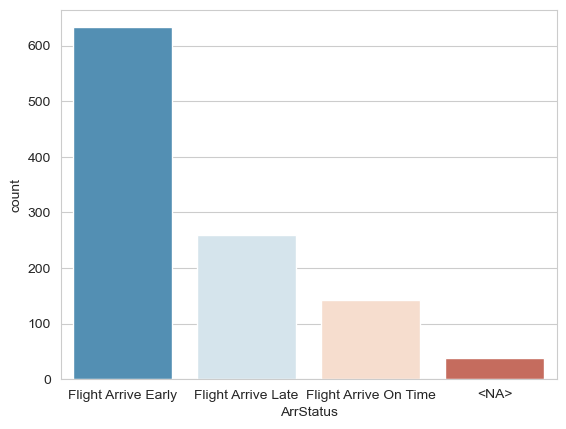

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='ArrStatus',data=df_clean,palette='RdBu_r')

**Is there any pattern between the departed hours and the arrival status of the flight**

Flight that take off between 5 and 8 AM are more likely to be late 

<Axes: xlabel='ArrStatus', ylabel='count'>

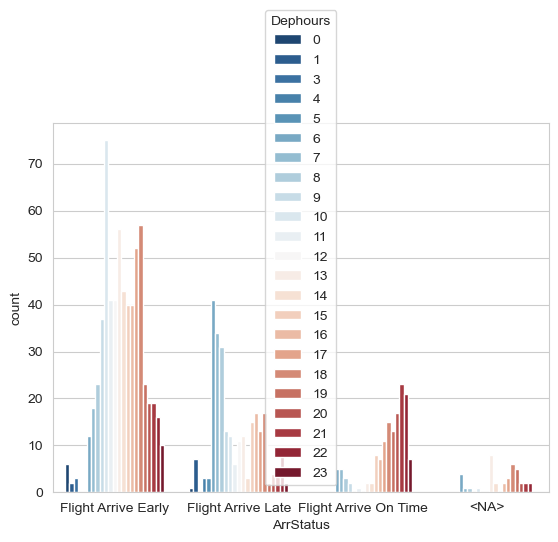

In [15]:
sns.set_style('whitegrid')
sns.countplot(x='ArrStatus',hue='Dephours',data=df_clean,palette='RdBu_r')

<Axes: title={'center': 'Distribution of the departure hour'}, xlabel='Hour of the day', ylabel='Count'>

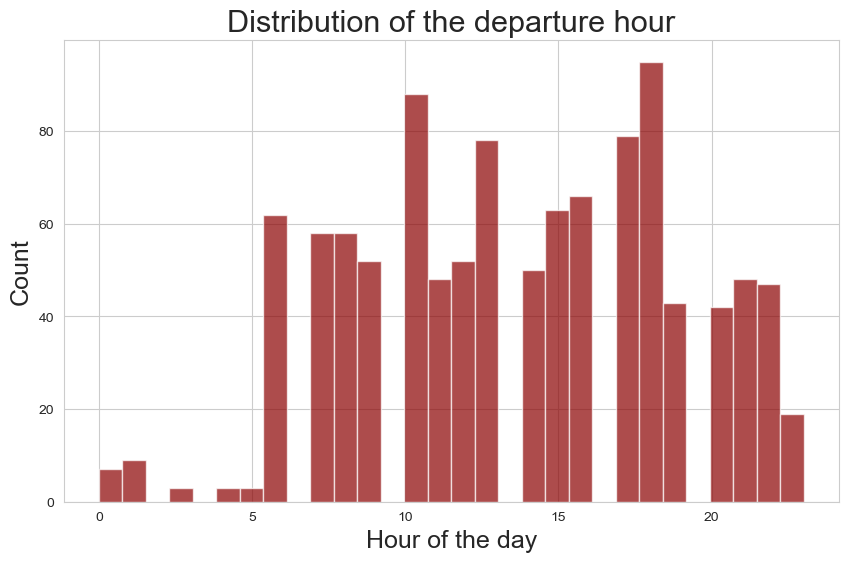

In [118]:
plt.xlabel("Hour of the day",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Distribution of the departure hour",fontsize=22)
df_clean['Dephours'].hist(bins=30,color='darkred',alpha=0.7,figsize=(10,6))

<font size="4">**Logistic Regression model fit and prediction**</font>

In [74]:
feats = df_clean.drop("ArrStatus", axis = 1)
target = df_clean["ArrStatus"]

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2, random_state = 42)
num_train = X_train[["Dephours", "Depminutes", "Arrhours", "Arrminutes"]]
num_test = X_test[["Dephours", "Depminutes", "Arrhours", "Arrminutes"]]

cat_train = X_train[["DepAirportCode", "ArrivalAirportCode", "OpAirlineID", "AircraftCode", "DepartStatus"]]
cat_test = X_test[["DepAirportCode", "ArrivalAirportCode", "OpAirlineID", "AircraftCode", "DepartStatus"]]

In [75]:
imp_cat = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")

cat_train= imp_cat.fit_transform(cat_train)
cat_test = imp_cat.transform(cat_test)


In [76]:
df_clean.isna().sum()
display(df_clean['ArrStatus'].value_counts()) 
display(df_clean['OpAirlineID'].value_counts()) 
display(df_clean['AircraftCode'].value_counts()) 

Flight Arrive Early      633
Flight Arrive Late       259
Flight Arrive On Time    142
<NA>                      39
Name: ArrStatus, dtype: int64

LH    915
CL    119
EN     24
4Y      8
OS      7
Name: OpAirlineID, dtype: int64

319    145
321    106
320     95
32A     94
CR9     90
333     79
343     66
74H     64
32Q     46
359     43
32N     41
32M     40
E90     37
78S     35
346     32
744     17
E95     16
35S     12
388     12
33Y      2
31K      1
Name: AircraftCode, dtype: int64

In [77]:
oe = OrdinalEncoder(categories=[["Flight Depart Early", "Flight Depart On Time", "Flight Depart Late"]], handle_unknown='use_encoded_value', unknown_value=np.nan)

cat_train = oe.fit_transform(X_train[['DepartStatus']])

cat_test = oe.transform(X_test[['DepartStatus']])

# Update the "DepartStatus" column in the training set
X_train['DepartStatus'] = cat_train


X_test['DepartStatus'] = cat_test

In [78]:
print(X_train)
print(X_test)

     DepAirportCode ArrivalAirportCode OpAirlineID AircraftCode  DepartStatus  \
1041            FRA                BOS          LH          343           NaN   
1071            BAH                RUH          LH          333           2.0   
243             FCO                FRA          LH          321           0.0   
801             FRA                ABV          LH          343           0.0   
884             FMO                FRA          CL          CR9           2.0   
...             ...                ...         ...          ...           ...   
330             MUC                ORD          LH          359           0.0   
466             FRA                BRE          LH          319           1.0   
121             FRA                HAM          LH          320           0.0   
1044            BOS                FRA          LH          343           1.0   
860             BER                FRA          LH          32Q           0.0   

      Dephours  Depminutes 

In [79]:
imputer = SimpleImputer(strategy='most_frequent')


cat_train = imputer.fit_transform(X_train[['DepartStatus']])

cat_test = imputer.transform(X_test[['DepartStatus']])


X_train['DepartStatus'] = cat_train
X_test['DepartStatus'] = cat_test

In [80]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)

y_test = label_encoder.transform(y_test)

In [81]:
X_train = np.concatenate((num_train, cat_train), axis=1)

X_test = np.concatenate((num_test, cat_test), axis=1)


print("Dimensions du tableau d'entraînement :", X_train.shape)
print("Dimensions du tableau de test :", X_test.shape)

Dimensions du tableau d'entraînement : (858, 5)
Dimensions du tableau de test : (215, 5)


In [82]:
lr = LogisticRegression(max_iter = 4400, random_state = 42)

lr.fit(X_train, y_train)

LogisticRegression(max_iter=4400, random_state=42)

In [87]:
y_lr_pred = lr.predict(X_test)

print(classification_report(y_test, y_lr_pred))
cm = confusion_matrix(y_test, y_lr_pred)

# Convert the confusion matrix array into a DataFrame
cm_df = pd.DataFrame(cm, index=['Class 0', 'Class 1', 'Class 2', 'Class 3'], columns=['Predicted Class 0', 'Predicted Class 1', 'Predicted Class 2', 'Predicted Class 3'])

# Display the confusion matrix DataFrame
cm_df

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.72      0.95      0.82       124
           2       0.74      0.33      0.46        51
           3       0.79      0.71      0.75        31

    accuracy                           0.73       215
   macro avg       0.56      0.50      0.51       215
weighted avg       0.70      0.73      0.69       215



,Predicted Class 0,Predicted Class 1,Predicted Class 2,Predicted Class 3
Class 0,0,9,0,0
Class 1,0,118,3,3
Class 2,0,31,17,3
Class 3,0,6,3,22


In [59]:
print("Score train set :", lr.score(X_train,y_train))
print("Score test set :", lr.score(X_test,y_test))

Score train set : 0.7599067599067599
Score test set : 0.7302325581395349


In [60]:
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test,y_lr_pred))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test,y_lr_pred))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test,y_lr_pred)))

Mean absolute error (MAE): 0.3116279069767442
Mean square error (MSE): 0.3953488372093023
Root mean square error (RMSE): 0.6287677132370127


In [84]:
print("R-squared value of predictions:",round(metrics.r2_score(y_test,y_lr_pred),3))

R-squared value of predictions: 0.364


<font size="4">**Random Forest Classifier model fit and prediction**</font>

Based on the confusion matrix, classification report and other metrics available, we can see that the model isn't as performant as it should be so we're going to try another model and parameter to see if we can boost those performance

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test data using the best model
y_rf_pred = best_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_rf_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_rf_pred)

# Convert the confusion matrix array into a DataFrame
cm_df = pd.DataFrame(cm, index=['Class 0', 'Class 1', 'Class 2', 'Class 3'], columns=['Predicted Class 0', 'Predicted Class 1', 'Predicted Class 2', 'Predicted Class 3'])

# Display the confusion matrix DataFrame
cm_df

              precision    recall  f1-score   support

           0       0.33      0.11      0.17         9
           1       0.78      0.93      0.85       124
           2       0.74      0.55      0.63        51
           3       0.93      0.81      0.86        31

    accuracy                           0.79       215
   macro avg       0.69      0.60      0.63       215
weighted avg       0.77      0.79      0.77       215



,Predicted Class 0,Predicted Class 1,Predicted Class 2,Predicted Class 3
Class 0,1,8,0,0
Class 1,1,115,8,0
Class 2,0,21,28,2
Class 3,1,3,2,25


In [94]:
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
print("Score train set:", best_model.score(X_train, y_train))
print("Score test set:", best_model.score(X_test, y_test))

# Calculate and print evaluation metrics
print("R-squared value of predictions:", round(metrics.r2_score(y_test, y_rf_pred), 3))
print("Mean absolute error (MAE):", mean_absolute_error(y_test, y_rf_pred))
print("Mean squared error (MSE):", mean_squared_error(y_test, y_rf_pred))
print("Root mean square error (RMSE):", np.sqrt(mean_squared_error(y_test, y_rf_pred)))


Score train set: 0.9044289044289044
Score test set: 0.786046511627907
R-squared value of predictions: 0.529
Mean absolute error (MAE): 0.2372093023255814
Mean squared error (MSE): 0.2930232558139535
Root mean square error (RMSE): 0.5413162253377904


In [95]:
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best Hyperparameters:
max_depth: 10
min_samples_split: 2
n_estimators: 300


The following cell can take up to an hour to run (recommanded to skip it and just play the next cell with the resulting parameters)

In [105]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.1, 0.05, 0.01],  # Shrinkage factor
    'max_depth': [3, 4, 5],  # Maximum depth of each tree
    'subsample': [0.8, 1.0],  # Fraction of samples used for training
    'min_samples_split': [2, 4],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider for the best split
}

# Create the Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)



Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.831014551883585


In [110]:


rf = RandomForestClassifier(random_state=42, n_estimators=300, min_samples_split=2, max_depth=10)
gb = GradientBoostingClassifier(random_state=42, learning_rate=0.05, max_depth=5, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8)

# Fit the base models on the training data
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Make predictions on the test data using the base models
y_rf_pred = rf.predict(X_test)
y_gb_pred = gb.predict(X_test)

# Perform model blending
y_blend_pred = np.round((y_rf_pred + y_gb_pred) / 2)

# Print classification report
print(classification_report(y_test, y_blend_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_blend_pred)

# Convert the confusion matrix array into a DataFrame
cm_df = pd.DataFrame(cm, index=['Class 0', 'Class 1', 'Class 2', 'Class 3'], columns=['Predicted Class 0', 'Predicted Class 1', 'Predicted Class 2', 'Predicted Class 3'])
print(confusion_matrix(y_test, y_test))
# Display the confusion matrix DataFrame
cm_df

              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.78      0.91      0.84       124
           2       0.72      0.55      0.62        51
           3       0.93      0.81      0.86        31

    accuracy                           0.78       215
   macro avg       0.71      0.62      0.65       215
weighted avg       0.77      0.78      0.77       215

[[  9   0   0   0]
 [  0 124   0   0]
 [  0   0  51   0]
 [  0   0   0  31]]


,Predicted Class 0,Predicted Class 1,Predicted Class 2,Predicted Class 3
Class 0,2,7,0,0
Class 1,2,113,9,0
Class 2,0,21,28,2
Class 3,1,3,2,25


In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Perform model blending
y_blend_pred = np.round((y_rf_pred + y_gb_pred) / 2)

# Calculate blend accuracy
blend_accuracy = accuracy_score(y_test, y_blend_pred)

# Calculate blend precision, recall, and F1-score for each class
blend_precision = precision_score(y_test, y_blend_pred, average=None)
blend_recall = recall_score(y_test, y_blend_pred, average=None)
blend_f1_score = f1_score(y_test, y_blend_pred, average=None)

# Print blend scores and metrics
print("Blend Accuracy:", blend_accuracy)
print("Blend Precision:", blend_precision)
print("Blend Recall:", blend_recall)
print("Blend F1-Score:", blend_f1_score)

Blend Accuracy: 0.7813953488372093
Blend Precision: [0.4        0.78472222 0.71794872 0.92592593]
Blend Recall: [0.22222222 0.91129032 0.54901961 0.80645161]
Blend F1-Score: [0.28571429 0.84328358 0.62222222 0.86206897]


In [107]:
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5)
cv_scores_gb = cross_val_score(gb, X_train, y_train, cv=5)

# Print cross-validation scores
print("Cross-validation Scores - Random Forest:")
print(cv_scores_rf)
print("Mean Cross-validation Score - Random Forest:", np.mean(cv_scores_rf))

print("Cross-validation Scores - Gradient Boosting:")
print(cv_scores_gb)
print("Mean Cross-validation Score - Gradient Boosting:", np.mean(cv_scores_gb))


Cross-validation Scores - Random Forest:
[0.84302326 0.74418605 0.85465116 0.81871345 0.88888889]
Mean Cross-validation Score - Random Forest: 0.829892560859513
Cross-validation Scores - Gradient Boosting:
[0.84883721 0.75581395 0.87790698 0.80116959 0.87134503]
Mean Cross-validation Score - Gradient Boosting: 0.831014551883585


In [108]:
print("Score train set - Random Forest:", rf.score(X_train, y_train))
print("Score test set - Random Forest:", rf.score(X_test, y_test))

print("Score train set - Gradient Boosting:", gb.score(X_train, y_train))
print("Score test set - Gradient Boosting:", gb.score(X_test, y_test))

# Calculate and print evaluation metrics
print("Mean absolute error (MAE) - Random Forest:", mean_absolute_error(y_test, y_rf_pred))
print("Mean squared error (MSE) - Random Forest:", mean_squared_error(y_test, y_rf_pred))
print("Root mean square error (RMSE) - Random Forest:", np.sqrt(mean_squared_error(y_test, y_rf_pred)))

print("Mean absolute error (MAE) - Gradient Boosting:", mean_absolute_error(y_test, y_gb_pred))
print("Mean squared error (MSE) - Gradient Boosting:", mean_squared_error(y_test, y_gb_pred))
print("Root mean square error (RMSE) - Gradient Boosting:", np.sqrt(mean_squared_error(y_test, y_gb_pred)))

Score train set - Random Forest: 0.9044289044289044
Score test set - Random Forest: 0.786046511627907
Score train set - Gradient Boosting: 0.9055944055944056
Score test set - Gradient Boosting: 0.7813953488372093
Mean absolute error (MAE) - Random Forest: 0.2372093023255814
Mean squared error (MSE) - Random Forest: 0.2930232558139535
Root mean square error (RMSE) - Random Forest: 0.5413162253377904
Mean absolute error (MAE) - Gradient Boosting: 0.2372093023255814
Mean squared error (MSE) - Gradient Boosting: 0.2744186046511628
Root mean square error (RMSE) - Gradient Boosting: 0.5238497920694087
